In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# !pip install catboost
from catboost import CatBoostClassifier
import time
import os
import json

In [3]:
subdir = "/content/drive/MyDrive/colab/hackfinal/"
# folder to load everything from and save everything to

In [4]:
os_stat = pd.read_csv(os.path.join(subdir, "os_stat.csv"))
areas_stat = pd.read_csv(os.path.join(subdir, "area.csv"))

with open(os.path.join(subdir, "apps_info.json"), "r") as f:
    bundle_info = json.load(f)

ios_translate_primaryGenre = {
     'Games': 'Игры',
     'Entertainment': 'Развлечения',
     'Photo & Video': 'Фотография',
     'Education': 'Образование',
     'Utilities': 'Инструменты',
     'Music': 'Музыка и аудио',
     'Lifestyle': 'Стиль жизни',
     'Social Networking': 'Социальные',
     'Health & Fitness': 'Здоровье и фитнес',
     'Productivity': 'Продуктивность',
     'Sports': 'Спорт',
     'Book': 'Книги и справочники',
     'Reference': 'Разное',
     'Finance': 'Финансы',
     'Navigation': 'Карты и навигация',
     'Travel': 'Путешествия',
     'Medical': 'Медицина',
     'Graphics & Design': 'Искусство и дизайн',
     'Business': 'Бизнес',
     'Shopping': 'Покупки',
     'Weather': 'Погода',
     'News': 'Новости',
     'Food & Drink': 'Еда и напитки',
     'Stickers': 'Стикеры',
}

for k,v in bundle_info.items():
    if v['os'] == 'ios':
        bundle_info[k]['genres'] = v['genres'].split(',')

for k,v in bundle_info.items():
    if v['os'] == 'ios':
        primaryGenreName = v['primaryGenreName']
        genre = ios_translate_primaryGenre[primaryGenreName]
        genres = v['genres']
        if genre == 'Игры':
            assert(genres[0] == 'Игры')
            if len(genres) > 1:
                genre = genres[1]
        bundle_info[k]['genre'] = genre

In [6]:
# load precalculated bundle descriptions embeddings

vectors_en = np.load(os.path.join(subdir, "embeddings_en.npy"))
vectors_ru = np.load(os.path.join(subdir, "embeddings_ru.npy"))
bundles_en = []
bundles_ru = []

with open(os.path.join(subdir, "bundles_en.txt"), "r") as f:
    for line in f:
        bundles_en.append(line.rstrip())

with open(os.path.join(subdir, "bundles_ru.txt"), "r") as f:
    for line in f:
        bundles_ru.append(line.rstrip())

vectors = np.concatenate([vectors_en, vectors_ru]) # np array of shape (N, 300)
bundles = bundles_en + bundles_ru # N strings representing bundle_ids

df_emb = pd.DataFrame(data=vectors, columns=[f'emb_{x}' for x in range(vectors.shape[1])])
df_emb['bundle'] = bundles
cols = df_emb.columns.tolist()
df_emb = df_emb[cols[len(cols)-1:len(cols)]+cols[:-1]]

In [66]:
# columns are column list of output X_array
# if you add same columns value when preprocessing different datasets, output X_array should have the same set of features
# if columns is None, columns will be selected automatically judging by set of unique values of some columns (when doing one hot encoding)
# return: dataframe, X_array, [y_array, if labeled=True], columns
def preprocess(df, labeled=True, columns=None):
    df[df.created == '1970-01-01T03:00:00.000000000'] = pd.Timestamp('2021-09-01T03:00:00.000000000')

    df['created'] = pd.to_datetime(df['created']) # assuming this is MSK time
    df['shift'] = df['shift'].fillna(value='MSK')
    df.loc[df['shift']=='MSK', 'shift'] += '+0'
    df['shift'] = df['shift'].str.slice(3,None).astype('int') # shift in hours from MSK
    df['created'] = df['created'] + pd.Timedelta(1, unit="h") * df['shift'] # now all time-related features are in local time

    df["hour"] = df['created'].dt.hour
    df["weekday"] = df['created'].dt.dayofweek
    df["weekstart"] = df['created'].dt.normalize() - pd.Timedelta(1, unit="d") * df['weekday']
    df = df.drop(columns=['created', 'shift', 'gamecategory', 'subgamecategory'])

    train_1 = df
    del df

    popular_areas = set(areas_stat["area"].unique())
    train_1["area"] = [k if k in popular_areas else "Прочее" for k in train_1["oblast"]]
    train_1 = pd.merge(train_1, areas_stat, left_on="area", right_on="area", how='left', suffixes=("", "_reg"))

    train_1["os_version"] = train_1["osv"].apply(lambda x: str(x).split(".")[0])
    popular_os = set(os_stat["os"].unique())
    train_1["os"] = [k if k in popular_os else "Прочее" for k in zip(train_1["os"], train_1["os_version"])]
    train_1 = pd.merge(train_1, os_stat, left_on="os", right_on="os", how='left', suffixes=("", "_os"))

    train_1["score"] = train_1["bundle"].apply(lambda x:
                                            (bundle_info[x].get("score") or bundle_info[x].get("averageUserRating"))
                                            if x in bundle_info else None)
    train_1["price"] = train_1["bundle"].apply(lambda x:
                                            bundle_info[x].get("price")
                                            if x in bundle_info else None)
    train_1["free"] = train_1["bundle"].apply(lambda x:
                                            (bundle_info[x].get("free") or bundle_info[x].get("price") == 0)
                                            if x in bundle_info else None)
    train_1["genre"] = train_1["bundle"].apply(lambda x:
                                            bundle_info[x].get("genre")
                                            if x in bundle_info else None)
    train_1["ratings"] = train_1["bundle"].apply(lambda x:
                                                bundle_info[x].get("ratings") or bundle_info[x].get("userRatingCount")
                                                if x in bundle_info else None)
    train_1["contentRating"] = train_1["bundle"].apply(lambda x:
                                                    (bundle_info[x].get("contentRating") or bundle_info[x].get("contentAdvisoryRating"))
                                                    if x in bundle_info else None)
    train_1["installs"] = train_1["bundle"].apply(lambda x:
                                                bundle_info[x].get("minInstalls")
                                                if x in bundle_info else None)

    train_1 = train_1.drop(columns=['oblast', 'os_version', 'osv'])

    for i in range(1,6):
        train_1[f'segment_{i}'] = train_1[f'segment_{i}'] / train_1['total']
        train_1[f'segment_{i}_os'] = train_1[f'segment_{i}_os'] / train_1['total_os']

    # one hot encoding
    train_dummy1 = pd.get_dummies(train_1['contentRating'], prefix='contentRating')
    train_1 = pd.concat([train_1, train_dummy1], axis=1)
    del train_dummy1

    # one hot encoding
    train_dummy1 = pd.get_dummies(train_1['genre'], prefix='genre')
    train_1 = pd.concat([train_1, train_dummy1], axis=1)
    del train_dummy1

    train_1['free_int'] = train_1['free'].fillna(True).astype('int')

    # add embeddings
    train_1 = pd.merge(train_1, df_emb, left_on="bundle", right_on="bundle", how='left', suffixes=("", "_reg"))

    if columns is None:
        columns = ['score', 'price', 'free_int', 'ratings', 'installs', 'hour', 'weekday'] \
                + [f'segment_{i}' for i in range(1,6)] \
                + [f'segment_{i}_os' for i in range(1,6)] \
                + [s for s in train_1.columns if s.startswith('genre_')] \
                + [s for s in train_1.columns if s.startswith('contentRating_')] \
                + [s for s in train_1.columns if s.startswith('emb_')]
    else:
        for col_name in columns:
            if not(col_name in train_1.columns):
                print("adding empty column {col_name}")
                train_1[col_name] = np.zeros(train_1.shape[0])

    X = np.array(train_1[columns])
    if labeled:
        y = np.array(train_1["Segment"]).astype('int')
    if X.dtype == 'float64':
        X = X.astype('float32')

    if labeled:
        return train_1, X, y, columns
    else:
        return train_1, X, columns

In [ ]:
# Datasets "train_part.csv" and "valid_part.csv" are obtained from "train.csv"
# using sklearn train_test_split with 0.2 ratio of test sample to whole dataset

In [13]:
# del df_train, X_train
df_train = pd.read_csv(os.path.join(subdir, "train_part.csv")) # 80% of original "train.csv" dataset
df_train = pd.read_csv(os.path.join(subdir, "train.csv")) # 80% of original "train.csv" dataset
print(df_train.shape)
df_train['index1'] = df_train.index # may be useful if dataset is subsampled
df_train = df_train.sample(frac=1/16, random_state=123) # choose part to sample if not enough RAM for whole dataset
print(df_train.shape)
df_train, X_train, y_train, X_train_columns = preprocess(df_train)
print(df_train.shape, X_train.shape)

(4485452, 10)
(280341, 11)
(280341, 401) (280341, 384)


In [15]:
# del df_val, X_val
df_val = pd.read_csv(os.path.join(subdir, "valid_part.csv")) # 20% of original "train.csv" dataset
print(df_val.shape)
df_val['index1'] = df_val.index
df_val = df_val.sample(frac=1/32, random_state=123) # choose part to sample if not enough RAM for whole dataset
print(df_val.shape)
df_val, X_val, y_val, _ = preprocess(df_val, columns=X_train_columns)
print(df_val.shape, X_val.shape)

(8970904, 10)
(280341, 11)
(280341, 402) (280341, 384)


In [ ]:
# del df_test, X_test

# code for calculating predictions on FULL test.csv dataset (for conditions will small RAM)
# can be found below, with splitting test.csv into parts

df_test = pd.read_csv(os.path.join(subdir, "test.csv")) # test dataset
print(df_test.shape)
df_test['index1'] = df_test.index
df_test = df_test.sample(frac=1, random_state=123) # choose part to sample if not enough RAM for whole dataset
print(df_test.shape)
df_test, X_test, _ = preprocess(df_test, labeled=False, columns=X_train_columns)
print(df_test.shape)

In [9]:
# if using another classifier that doesn't accept NaNs in X:

# if need to remove rows with nans in X,y

# print(X_train.shape)
# nan_idx = np.isnan(X_train).any(axis=1)
# y_train_dropna = y_train[~nan_idx]
# X_train_dropna = X_train[~nan_idx]
# print(X_train_dropna.shape) # number of rows may change

# if need to fill nans in X with zeros

# X_val_fillna = np.nan_to_num(X_val, copy=True, nan=0., posinf=None, neginf=None) # same dimensions

(280341, 384)
(240973, 384)
47.996257305145264


In [16]:
cls = CatBoostClassifier()

In [18]:
# either load fitted model
cls.load_model(os.path.join(subdir, 'model_123.cbm'), format='cbm')

In [ ]:
# or fit a new model
cls.fit(X_train, y_train)

In [19]:
y_val_pred_proba = cls.predict_proba(X_val)
y_val_pred = cls.predict(X_val).flatten()
score = cls.score(X_val, y_val)
print(score) # accuracy

0.5771792210201148


In [ ]:
# save model
from datetime import datetime
date_str = datetime.now().isoformat().replace(':','.')[:19]
cls.save_model(f"/content/hackfinal/model_{date_str}.cbm",
                format="cbm",
                export_parameters=None,
                pool=None)

In [ ]:
# !cp /content/hackfinal/*.cbm /content/drive/MyDrive/colab/hackfinal/

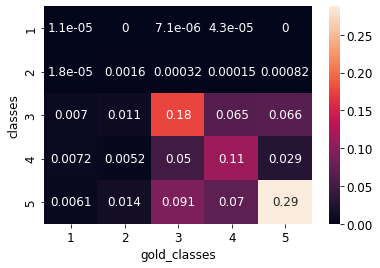

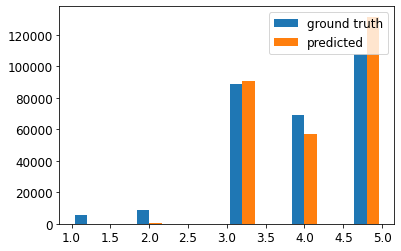

In [24]:
# prediction quality plots, part 1

plt.rcParams['axes.facecolor'] = 'white'

from collections import defaultdict
import seaborn as sns
cntr = defaultdict(int)
for gold, cl in zip(y_val, y_val_pred):
    cntr[(cl, gold)] += 1

cl = []
gld = []
cnte = []
for key, value in cntr.items():
    cl.append(key[0])
    gld.append(key[1])
    cnte.append(value)
d = pd.DataFrame(dict(gold_classes=y_val, classes=y_val_pred, cntr=[1] * len(y_val_pred)))

d = d.groupby(["classes", "gold_classes"]).count().apply(lambda x: x / len(y_val)).reset_index().pivot("classes", "gold_classes", "cntr")
d = d.fillna(value=0.)
ax = plt.axes()

sns.heatmap(d, annot=True, ax=ax)
plt.show()
plt.hist([y_val, y_val_pred], label=['ground truth', 'predicted'])
plt.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


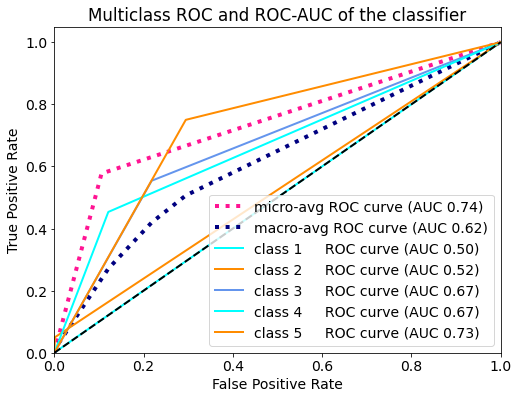

In [30]:
# ROC AUC plots for multiclass classification
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score

n_classes = 5
classes = list(range(1,1+n_classes))
# Binarize the output
y_val_pred_bin = label_binarize(y_val_pred, classes=classes)
y_val_bin = label_binarize(y_val.astype('int'), classes=classes)



plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 14

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_val_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

######

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-avg ROC curve (AUC {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-avg ROC curve (AUC {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw = 2
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="class {0}     ROC curve (AUC {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC and ROC-AUC of the classifier")
plt.legend(loc="lower right")
plt.show()

In [34]:
# classification report
from sklearn.metrics import classification_report
report = classification_report(y_val, y_val_pred, output_dict=True)
report

{'1': {'f1-score': 0.001049317943336831,
  'precision': 0.17647058823529413,
  'recall': 0.0005262234695667427,
  'support': 5701},
 '2': {'f1-score': 0.09173166926677068,
  'precision': 0.5457920792079208,
  'recall': 0.050073804927898265,
  'support': 8807},
 '3': {'f1-score': 0.5474126667296796,
  'precision': 0.5410205404930158,
  'recall': 0.553957644093354,
  'support': 88866},
 '4': {'f1-score': 0.4980697424213658,
  'precision': 0.5524357714446161,
  'recall': 0.4534454943535377,
  'support': 69424},
 '5': {'f1-score': 0.6747001054022854,
  'precision': 0.6131548338540835,
  'recall': 0.7499790781361874,
  'support': 107543},
 'accuracy': 0.5771792210201148,
 'macro avg': {'f1-score': 0.3625927003526877,
  'precision': 0.48577476264698605,
  'recall': 0.3615964489961089,
  'support': 280341},
 'weighted avg': {'f1-score': 0.5585965101343221,
  'precision': 0.5642556469103935,
  'recall': 0.5771792210201148,
  'support': 280341}}

In [ ]:
# del df_test_full
df_test_full = pd.read_csv(os.path.join(subdir, "test.csv")) # test dataset
df_test_full['index1'] = df_test_full.index

In [ ]:
part_len = 200000

part_starts = list(range(0, len(df_test_full), part_len))
print('parts:', [(i, min(i+part_len, len(df_test_full))) for i in part_starts])
y_pred_proba_full = []
for part_start in part_starts:
    print('processing test rows', part_start, '--', min(part_start+part_len, len(df_test_full)))
    df_test = df_test_full.iloc[part_start:part_start+part_len].copy()
    # print(df_test.shape)
    df_test, X_test, _ = preprocess(df_test, labeled=False, columns=X_train_columns)
    y_pred_proba = cls.predict_proba(X_test)
    y_pred_proba_full.append(y_pred_proba)
    del df_test, X_test
y_pred_proba = np.concatenate(y_pred_proba_full)
print(df_test_full.shape, y_pred_proba.shape)

In [ ]:
with open(os.path.join(subdir, "test_predict_proba.npy"), "wb") as f:
    np.save(f, y_pred_proba)

In [ ]:
# CLUSTERIZATION starts here
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

X = StandardScaler().fit_transform(X_train_dropna[:10000])
clust = AgglomerativeClustering(n_clusters=5) #, linkage="complete")
clust.fit(X)

In [39]:
tsne = TSNE(n_components=2)
comp = tsne.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


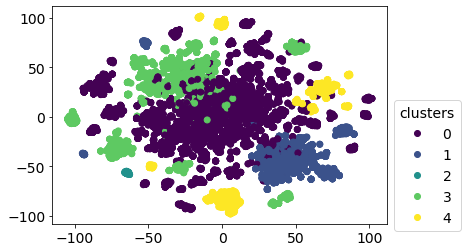

In [55]:
fig, ax = plt.subplots()
sc = ax.scatter(comp[:,0], comp[:,1], c=clust.labels_)
ax.legend(*sc.legend_elements(), title='clusters', bbox_to_anchor = [1.0, 0.6])

In [ ]:
# from sklearn.metrics import adjusted_rand_score
# adjusted_rand_score(y1, y2)